# Classification for Stars vs. Non-Stellar Objects 


#### In this notebook, we will explore the RefCat data for analyzing and extracting train data sets for **labels of stars**.

#### Some Issues:
- Repartitioned Reference Catalog is now fine. The direct conversions from astropy tables had many inefficient partition issues. 
- Huge Size of Data. Hence, we may need a memory-intensive configuration of Spark Session.  

## Import Basic Packages 

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

# Increase display width to 200 characters
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 200)

In [2]:
import os

from astropy.table import Table
from matplotlib.ticker import MultipleLocator

from astropy.utils.exceptions import AstropyWarning
import warnings
warnings.simplefilter('ignore', category=AstropyWarning)

In [3]:
# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

## PySpark Session

In [4]:
%%time
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "200") \
    .config("spark.sql.hive.filesourcePartitionFileCacheSize", "2097152000") \
    .getOrCreate()



sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

CPU times: user 10 ms, sys: 10.7 ms, total: 20.7 ms
Wall time: 32.5 s


> This takes time to get resources from the Yarn Cluster

## Reading Reference Catalog Files

- Now we have a repartioned RefCat parquet file, which works well in PySpark. 

In [5]:
!pwd

/home/shong/work/deeplearnings/star-classification/notebook


In [6]:
datapath = '/user/shong/data/spherex/star-classification/reduced-data/'
hdfsheader = 'hdfs://spark00:54310'
localdatapath= '/home/shong/work/deeplearnings/star-classification/data/'

In [7]:
hdfsheader+datapath+'RefCat-Repartitioned.parquet.snappy'

'hdfs://spark00:54310/user/shong/data/spherex/star-classification/reduced-data/RefCat-Repartitioned.parquet.snappy'

In [8]:
%%time
alldf = spark.read.option("header","true").parquet(hdfsheader+datapath+'RefCat-Repartitioned.parquet.snappy')

CPU times: user 2.26 ms, sys: 106 µs, total: 2.36 ms
Wall time: 2.04 s


In [9]:
alldf.printSchema()

root
 |-- SPHERExRefID: long (nullable = true)
 |-- Gaia_DR3_source_id: long (nullable = true)
 |-- LegacySurvey_uid: long (nullable = true)
 |-- PS1_DR1_StackObject_objID: long (nullable = true)
 |-- CatWISE_source_id: string (nullable = true)
 |-- AllWISE_designation: string (nullable = true)
 |-- 2MASS_designation: string (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- ra_error: double (nullable = true)
 |-- dec_error: double (nullable = true)
 |-- coord_src: long (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmra_error: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- pmdec_error: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: double (nullable = true)
 |-- ref_epoch: double (nullable = true)
 |-- astrometric_params_solved: short (nullable = true)
 |-- CatWISE_PMRA: double (nullable = true)
 |-- CatWISE_PMDec: double (nullable = true)
 |-- CatWISE_sigPMRA: double (nullab

In [10]:
#%%time
#alldf.limit(4).toPandas().T

In [11]:
#%%time
#alldf.count()

```
CPU times: user 1.77 ms, sys: 0 ns, total: 1.77 ms
Wall time: 4.4 s
5830093820
```

# Compare Gaia, PanStarrs, Legacy, and CatWISE catalogs

- GaiaDR3: 1.81B
- PanStarrsDR1: ??
- DESI Legacy: 3.14B
- CatWISE2020: 1.89B

#### Catalog Matching Flag: 1x(GaiaBoolean) + 2x(PanStarrsBoolean) + 4x(LegacyBoolean) + 8x(CatWISEBoolean)

- 0 - 15: <br> 0 (None), 1 (Gaia Only), 2 (PanStarrs Only), 3 (Gaia + PanStarrs), 4 (Legacy Only), <br> 
5 (Gaia + Legacy), 6 (PanStarr + Legacy), 7 (Gaia + PanStarr + Legacy), <br>
8 (CatWISE Only), 9 (CatWISE + Gaia) ...


In [12]:
def getMatchingFlag(idgaia,idpanstarr,idlegacy,idcat):
    boolgaia = 0
    boolpan = 0
    boollegacy = 0
    boolcat = 1
    if (idgaia > -1):
        boolgaia =1 
    if (idpanstarr > -1):
        boolpan =1 
    if (idlegacy > -1):
        boollegacy = 1
    if (idcat == 'N/A'):
        boolcat = 0
    
    iflag = 1 * boolgaia + 2* boolpan + 4*boollegacy + 8*boolcat
        
    return iflag

In [13]:
[getMatchingFlag(100,100,-9999,'aa'),getMatchingFlag(-9999,3,-9999,'N/A'),getMatchingFlag(-9999,-9999,-9999,'N/A')]

[11, 2, 0]

#### UDF

In [14]:
getCatFlag = F.udf(getMatchingFlag,T.ShortType())

In [15]:
flagdf = alldf.withColumn('MatchingFlag', \
                      getCatFlag(F.col('Gaia_DR3_source_id'), F.col('LegacySurvey_uid'), \
                                 F.col('PS1_DR1_StackObject_objID'), F.col('CatWISE_source_id')))

In [16]:
flagdf.cache()

DataFrame[SPHERExRefID: bigint, Gaia_DR3_source_id: bigint, LegacySurvey_uid: bigint, PS1_DR1_StackObject_objID: bigint, CatWISE_source_id: string, AllWISE_designation: string, 2MASS_designation: string, ra: double, dec: double, ra_error: double, dec_error: double, coord_src: bigint, pmra: double, pmra_error: double, pmdec: double, pmdec_error: double, parallax: double, parallax_error: double, ref_epoch: double, astrometric_params_solved: smallint, CatWISE_PMRA: double, CatWISE_PMDec: double, CatWISE_sigPMRA: double, CatWISE_sigPMDec: double, Gaia_G: double, Gaia_BP: double, Gaia_RP: double, Gaia_G_error: double, Gaia_BP_error: double, Gaia_RP_error: double, LS_g: double, LS_r: double, LS_z: double, LS_g_error: double, LS_r_error: double, LS_z_error: double, PS1_g: double, PS1_r: double, PS1_i: double, PS1_z: double, PS1_y: double, PS1_g_error: double, PS1_r_error: double, PS1_i_error: double, PS1_z_error: double, PS1_y_error: double, 2MASS_J: double, 2MASS_H: double, 2MASS_Ks: double,

#### Basic Flag Statistics

In [17]:
#histo_flags = flagdf.groupBy('MatchingFlag').count().orderBy(F.col('MatchingFlag').asc())

In [18]:
#%%time
#histoflagpdf = histo_flags.toPandas()

CPU times: user 330 ms, sys: 277 ms, total: 608 ms
Wall time: 17min 29s


```
CPU times: user 330 ms, sys: 277 ms, total: 608 ms
Wall time: 17min 29s
```

In [19]:
#histoflagpdf.to_parquet('../data/histo-flag-refcat-pdf.parquet')

In [23]:
histoflagpdf = pd.read_parquet('../data/histo-flag-refcat-pdf.parquet')

In [24]:
histoflagpdf

,MatchingFlag,count
0,0,50849115
1,1,593238844
2,2,2149824592
3,3,33809189
4,4,415740570
5,5,429352359
6,6,150471609
7,7,31665647
8,8,584375599
9,9,213770134


In [25]:
histoflagpdf.set_index('MatchingFlag')

,count
MatchingFlag,
0,50849115
1,593238844
2,2149824592
3,33809189
4,415740570
5,429352359
6,150471609
7,31665647
8,584375599


- Catalog Matching Flag: **1x(GaiaBoolean) + 2x(PanStarrsBoolean) + 4x(LegacyBoolean) + 8x(CatWISEBoolean)**
- `MatchingFlag == 15` is the maximally informative subsample.

In [26]:
listflag = histoflagpdf.MatchingFlag.values
listcountflag = histoflagpdf['count'].values

In [27]:
print(listflag)
print(listcountflag)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[  50849115  593238844 2149824592   33809189  415740570  429352359
  150471609   31665647  584375599  213770134  375398865   72297288
   98926829  304120447  192796870  133455863]


In [28]:
histoflagpdf['count'].sum()

5830093820

> Sanity Checks

In [29]:
#%%time
#sample_flagdf = flagdf.limit(4).toPandas().T

CPU times: user 292 ms, sys: 291 ms, total: 583 ms
Wall time: 20min 24s


```
CPU times: user 292 ms, sys: 291 ms, total: 583 ms
Wall time: 20min 24s
```

In [33]:
#sample_flagdf.T.to_parquet('../data/sample-flagdf-show.parquet')

In [34]:
sample_flagdf = pd.read_parquet('../data/sample-flagdf-show.parquet')

In [35]:
sample_flagdf.T

,0,1,2,3
SPHERExRefID,2397637034589028394,2573000184212488195,2564133125412093973,2565821885111599150
Gaia_DR3_source_id,4116757974710525440,4051095758790412288,4049855093088110464,4049850630618036736
LegacySurvey_uid,-9999,-9999,-9999,-9999
PS1_DR1_StackObject_objID,80722648871594149,72962757299530043,-9999,73292739654505964
CatWISE_source_id,N/A,N/A,N/A,N/A
AllWISE_designation,N/A,N/A,N/A,N/A
2MASS_designation,N/A,N/A,N/A,N/A
ra,264.887154,275.729773,274.200006,273.965485
dec,-22.730242,-29.200199,-28.860741,-28.920204
ra_error,0.0,0.0,0.000002,0.0


# Most Informative Subsample (MIS) :  `MatchingFlag == 15`

In [41]:
misdf = flagdf.filter(F.col("MatchingFlag") == 15)

> **MIS** has all photometries from the 4 major catalogs. <br> 
Still, MIS has some `-9999` values, which are actually `Null`. 

### Remove rows with `-9999`

> replace `< -9998` as `Null` (or `None`)

In [42]:
listcol = flagdf.columns

In [43]:
listcol[24:46]

['Gaia_G',
 'Gaia_BP',
 'Gaia_RP',
 'Gaia_G_error',
 'Gaia_BP_error',
 'Gaia_RP_error',
 'LS_g',
 'LS_r',
 'LS_z',
 'LS_g_error',
 'LS_r_error',
 'LS_z_error',
 'PS1_g',
 'PS1_r',
 'PS1_i',
 'PS1_z',
 'PS1_y',
 'PS1_g_error',
 'PS1_r_error',
 'PS1_i_error',
 'PS1_z_error',
 'PS1_y_error']

In [44]:
listcol[52:56]

['WISE_W1', 'WISE_W2', 'WISE_W1_error', 'WISE_W2_error']

In [45]:
listvalcol = listcol[24:46]+listcol[52:56]
print(listvalcol)

['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'Gaia_G_error', 'Gaia_BP_error', 'Gaia_RP_error', 'LS_g', 'LS_r', 'LS_z', 'LS_g_error', 'LS_r_error', 'LS_z_error', 'PS1_g', 'PS1_r', 'PS1_i', 'PS1_z', 'PS1_y', 'PS1_g_error', 'PS1_r_error', 'PS1_i_error', 'PS1_z_error', 'PS1_y_error', 'WISE_W1', 'WISE_W2', 'WISE_W1_error', 'WISE_W2_error']


In [46]:
df = misdf

In [47]:
for eachcol in listvalcol:
    df = df.withColumn(eachcol, F.when(F.col(eachcol) < -9998, F.lit(None)).otherwise(F.col(eachcol)))

In [48]:
df.cache()

DataFrame[SPHERExRefID: bigint, Gaia_DR3_source_id: bigint, LegacySurvey_uid: bigint, PS1_DR1_StackObject_objID: bigint, CatWISE_source_id: string, AllWISE_designation: string, 2MASS_designation: string, ra: double, dec: double, ra_error: double, dec_error: double, coord_src: bigint, pmra: double, pmra_error: double, pmdec: double, pmdec_error: double, parallax: double, parallax_error: double, ref_epoch: double, astrometric_params_solved: smallint, CatWISE_PMRA: double, CatWISE_PMDec: double, CatWISE_sigPMRA: double, CatWISE_sigPMDec: double, Gaia_G: double, Gaia_BP: double, Gaia_RP: double, Gaia_G_error: double, Gaia_BP_error: double, Gaia_RP_error: double, LS_g: double, LS_r: double, LS_z: double, LS_g_error: double, LS_r_error: double, LS_z_error: double, PS1_g: double, PS1_r: double, PS1_i: double, PS1_z: double, PS1_y: double, PS1_g_error: double, PS1_r_error: double, PS1_i_error: double, PS1_z_error: double, PS1_y_error: double, 2MASS_J: double, 2MASS_H: double, 2MASS_Ks: double,

In [49]:
#%%time
#stats_df = df.select(listvalcol).describe().toPandas()

CPU times: user 228 ms, sys: 395 ms, total: 623 ms
Wall time: 18min 20s


```
CPU times: user 228 ms, sys: 395 ms, total: 623 ms
Wall time: 18min 20s
```

In [50]:
#stats_df.to_parquet('../data/mis-null-stats.parquet')

In [51]:
stats_df = pd.read_parquet('../data/mis-null-stats.parquet')

In [52]:
stats_df.T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Gaia_G,133349665,608.4390892583517,3779.0789916947547,2.746002197265625,1.2335072E7
Gaia_BP,132873811,432.35854628042694,3191.8435736422543,0.26731404662132263,1.3412304E7
Gaia_RP,133183392,886.8740288056595,4963.425462313484,0.47794732451438904,9872609.0
Gaia_G_error,133349665,1.185741666792139,8.09965118077519,0.0683758735119389,22816.580918542983
Gaia_BP_error,132873811,2.9673585595310055,12.56321533721439,6.225818832033819E-4,56893.206375762864
Gaia_RP_error,133183392,4.621112944942819,32.711921519303644,0.0018402051802578405,168118.89291928316
LS_g,133455724,1434.914199800561,1956591.1543255812,-9965.98046875,3.630780416E9
LS_r,133455670,1340.2702659444385,1648947.019355935,-9896.0390625,3.630780416E9
LS_z,133455676,1993.7687080718456,2004099.5526638727,-9868.3876953125,3.630780416E9


> Again, negative Jansky for Legacy Survey?!?. This is due to *forced photometry*. We may ignore such negative jansky objects. 

#### Final Train Set

In [53]:
traindf = df.dropna()

In [54]:
%%time
stats_train = traindf.select(listvalcol).describe().toPandas()

CPU times: user 183 ms, sys: 159 ms, total: 342 ms
Wall time: 44.9 s


In [56]:
#stats_train.to_parquet('../data/train-stats.parquet')

In [55]:
stats_train.T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Gaia_G,97529175,648.6220104217754,2062.0059743030038,2.746002197265625,190015.5
Gaia_BP,97529175,462.86851167967654,1541.4972337272168,0.26731404662132263,156261.828125
Gaia_RP,97529175,937.5315135793138,2845.0395129623957,0.48395025730133057,382920.3125
Gaia_G_error,97529175,1.2522491313728379,3.9354252209600507,0.0683758735119389,1632.9657766341209
Gaia_BP_error,97529175,3.0201545809317323,6.767950088682359,6.225818832033819E-4,7305.160273729921
Gaia_RP_error,97529175,4.6977710710373435,9.34949313454147,0.0018402051802578405,9253.940722944228
LS_g,97529175,447.981538284785,283238.3264429876,-9907.498046875,2.744475904E9
LS_r,97529175,761.815166747817,195194.91597879824,-9896.0390625,1.521134336E9
LS_z,97529175,1043.1949743558885,145872.0280164497,-9361.9296875,1.342438016E9


# Bias Analyses 

### Gaia vs. Train Set

In [57]:
colgaia = ['Gaia_G','Gaia_BP','Gaia_RP','Gaia_G_error','Gaia_BP_error','Gaia_RP_error']

### `Gaia_G` 

In [58]:
tempbins = np.arange(101)*200
print(tempbins)

[    0   200   400   600   800  1000  1200  1400  1600  1800  2000  2200
  2400  2600  2800  3000  3200  3400  3600  3800  4000  4200  4400  4600
  4800  5000  5200  5400  5600  5800  6000  6200  6400  6600  6800  7000
  7200  7400  7600  7800  8000  8200  8400  8600  8800  9000  9200  9400
  9600  9800 10000 10200 10400 10600 10800 11000 11200 11400 11600 11800
 12000 12200 12400 12600 12800 13000 13200 13400 13600 13800 14000 14200
 14400 14600 14800 15000 15200 15400 15600 15800 16000 16200 16400 16600
 16800 17000 17200 17400 17600 17800 18000 18200 18400 18600 18800 19000
 19200 19400 19600 19800 20000]


In [59]:
mybins = tempbins.tolist()

In [60]:
%%time
bins, traincounts = \
    traindf.select('Gaia_G').rdd.flatMap(lambda x: x).histogram(mybins)

CPU times: user 333 ms, sys: 115 ms, total: 448 ms
Wall time: 7.89 s


In [69]:
%%time
bins, totalcounts = \
    flagdf.filter(F.col("Gaia_DR3_source_id") > 0). \
        select('Gaia_G').rdd.flatMap(lambda x: x).histogram(mybins)

CPU times: user 338 ms, sys: 336 ms, total: 673 ms
Wall time: 18min 57s


In [70]:
leftbins = [x - 100 for x in bins]

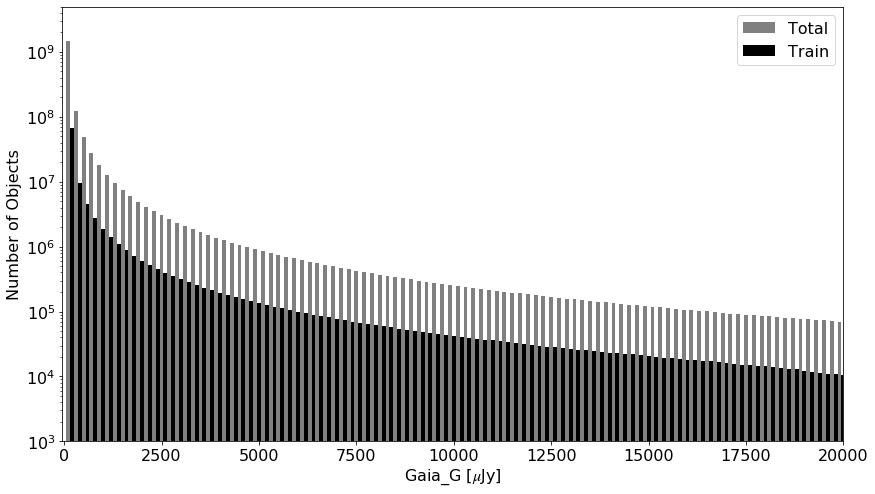

In [82]:
#bins, counts

#plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'


fig = plt.figure(figsize=(14,8))

plt.axis([-50,20000,1.0e3,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'Gaia_G [$\mu$Jy]')
plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftbins[1:],totalcounts,color='grey',width=100, label='Total')
plt.bar(bins[1:],traincounts,color='black',width=100, label='Train')

# Add legend
plt.legend()

fig.savefig("histo_gaia_g.pdf")

plt.show()

> **Our training sample** is not much biased. 

#### Save `traindf` and  `flagdf` for later usages

In [83]:
%%time
traindf.write.option("compression", "snappy").mode("overwrite") \
    .save(hdfsheader+datapath+'RefCat-Train.parquet.snappy')   

CPU times: user 269 ms, sys: 287 ms, total: 556 ms
Wall time: 13min 48s


In [84]:
%%time
flagdf.write.option("compression", "snappy").mode("overwrite") \
    .save(hdfsheader+datapath+'RefCat-Flagged.parquet.snappy')    

CPU times: user 773 ms, sys: 634 ms, total: 1.41 s
Wall time: 4h 9min 57s
